In [1]:
import re
import numpy as np
import csv
import matplotlib.pyplot as plt
import random

In [2]:
poems = []

with open('data.csv', 'r', encoding='utf-8') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        if random.random() < 0.03:  # Randomly decide whether to include this row
            poem_content = row['content']
            poems.append(poem_content)

In [3]:

poems = [re.sub(r'[^\w\s]', '', poem) for poem in poems]
poems = [re.sub(r'[\s\n]', '', poem) for poem in poems]

# 去重
vocab = set("".join(poems))

# 长度就是模型接受的大小
vocab_size = len(vocab)
# 加密解密
char_to_index = {char: i for i, char in enumerate(vocab)}
index_to_char = {i: char for i, char in enumerate(vocab)}



In [12]:
# 模型参数初始化
input_size = vocab_size
hidden_size = 5 # 可以调整这个值以优化模型
output_size = vocab_size
rate = 0.01

Wxh = np.random.randn(hidden_size, input_size) * 0.01
Whh = np.random.randn(hidden_size, hidden_size) * 0.01
Why = np.random.randn(output_size, hidden_size) * 0.01
bh = np.zeros((hidden_size, 1))
by = np.zeros((output_size, 1))

In [15]:

# 前向和后向传播
def forward_backward(inputs, targets, hprev):
    xs, hs, ys, ps = {}, {}, {}, {}
    # RNN通过上一次的h与x共同作用
    hs[-1] = np.copy(hprev)
    loss = 0

    for t in range(len(inputs)):
        xs[t] = np.zeros((input_size, 1))
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh)
        ys[t] = np.dot(Why, hs[t]) + by
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))
        loss += -np.log(ps[t][targets[t], 0])

    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])

    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext
        dhraw = (1 - hs[t] * hs[t]) * dh
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)

    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]


In [14]:
# 每五个为一个序列
length = 25 
# 训练参数
num = 500000  # 迭代次数
patience = 800   # 耐心值

In [16]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [17]:
def train(data, num, patience=500):
    global Wxh, Whh, Why, bh, by  # 全局

    lowest_loss = np.inf # 迭代找最小
    best = {}
    counter = 0

    n, p = 0, 0
    hprev = np.zeros((hidden_size, 1))
    losses = [] # 记录loss
    lossess = []
    for i in range(num):
        if p + length + 1 >= len(data) or n == 0:
            hprev = np.zeros((hidden_size, 1))
            p = 0  

        inputs = [char_to_index[data[p]]]
        targets = [char_to_index[ch] for ch in data[p+1:p+length+1]]

        loss, dWxh, dWhh, dWhy, dbh, dby, hprev = forward_backward(inputs, targets, hprev)

        # 梯度下降
        for param, dparam in zip([Wxh, Whh, Why, bh, by], [dWxh, dWhh, dWhy, dbh, dby]):
            param += -rate * dparam

        p += length  
        n += 1  
        if n%10 ==0:
            lossess.append(loss)
        if n % 200 == 0:
            print(f"Epoch {n}, Loss: {loss}")
            losses.append(loss)
        
        if loss < lowest_loss:
            lowest_loss = loss
            best = {
                'Wxh': Wxh.copy(), 
                'Whh': Whh.copy(), 
                'Why': Why.copy(), 
                'bh': bh.copy(), 
                'by': by.copy()
            }
            counter = 0
        else:
            counter += 1


    Wxh, Whh, Why, bh, by = best.values()
    plt.plot(range(len(losses)),losses)
    plt.xlabel('num')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    plt.scatter(range(len(lossess)), lossess, color='red', marker='o')
    plt.xlabel('num')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    return best, lowest_loss

Epoch 200, Loss: 6.43243525018416
Epoch 400, Loss: 6.395978049753253
Epoch 600, Loss: 6.3599315660208795
Epoch 800, Loss: 6.323286245377886
Epoch 1000, Loss: 6.287960126616589
Epoch 1200, Loss: 6.251644294279625
Epoch 1400, Loss: 6.2159194420145
Epoch 1600, Loss: 6.178921103384807
Epoch 1800, Loss: 6.148098407476705
Epoch 2000, Loss: 6.111592682644724
Epoch 2200, Loss: 6.074547663347626
Epoch 2400, Loss: 6.041827850055317
Epoch 2600, Loss: 5.993920246486463
Epoch 2800, Loss: 5.9481447558372995
Epoch 3000, Loss: 5.906815582651408
Epoch 3200, Loss: 5.867892192216794
Epoch 3400, Loss: 5.780106228730531
Epoch 3600, Loss: 5.696582776675343
Epoch 3800, Loss: 5.548804069820202
Epoch 4000, Loss: 5.4377819892770995
Epoch 4200, Loss: 5.230486520519791
Epoch 4400, Loss: 5.191073390199669
Epoch 4600, Loss: 3.9009318041184047
Epoch 4800, Loss: 4.922216677438896
Epoch 5000, Loss: 5.010175193899993
Epoch 5200, Loss: 4.752140504081034
Epoch 5400, Loss: 4.699441230920385
Epoch 5600, Loss: 4.60559507919

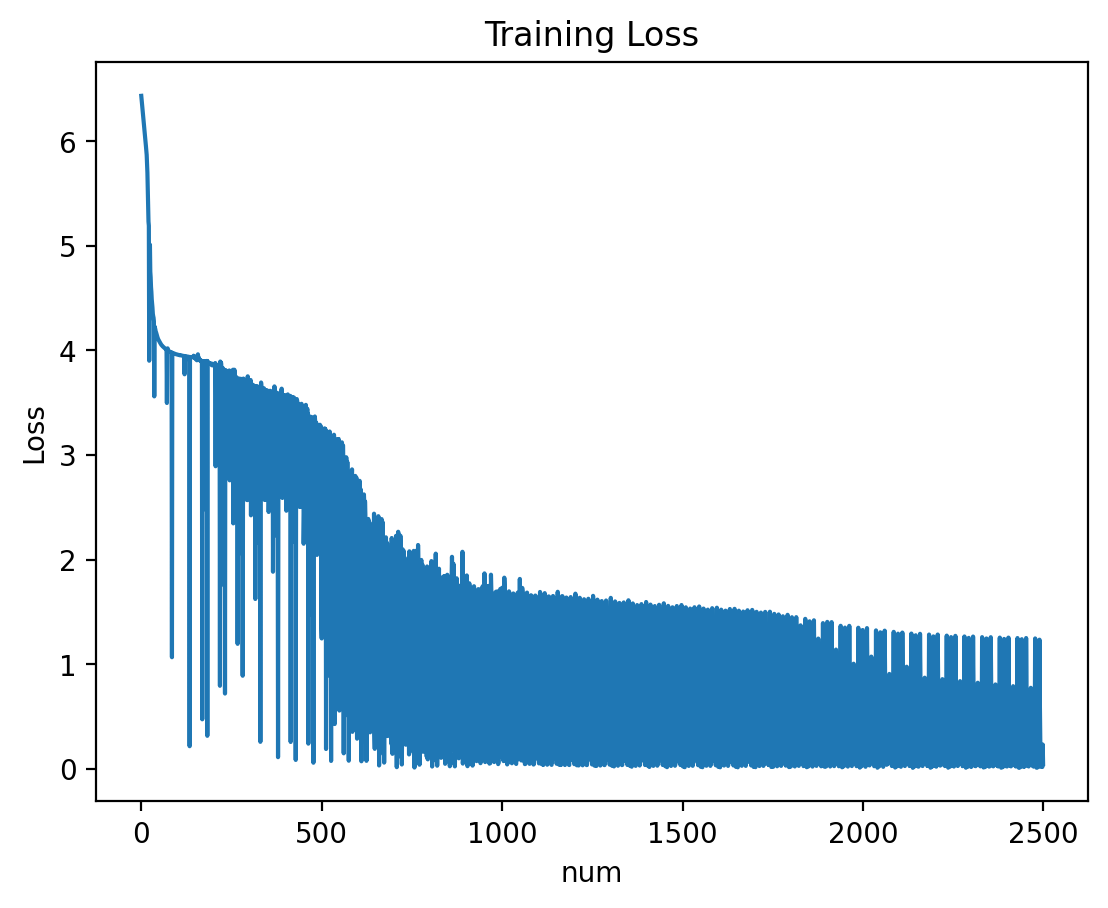

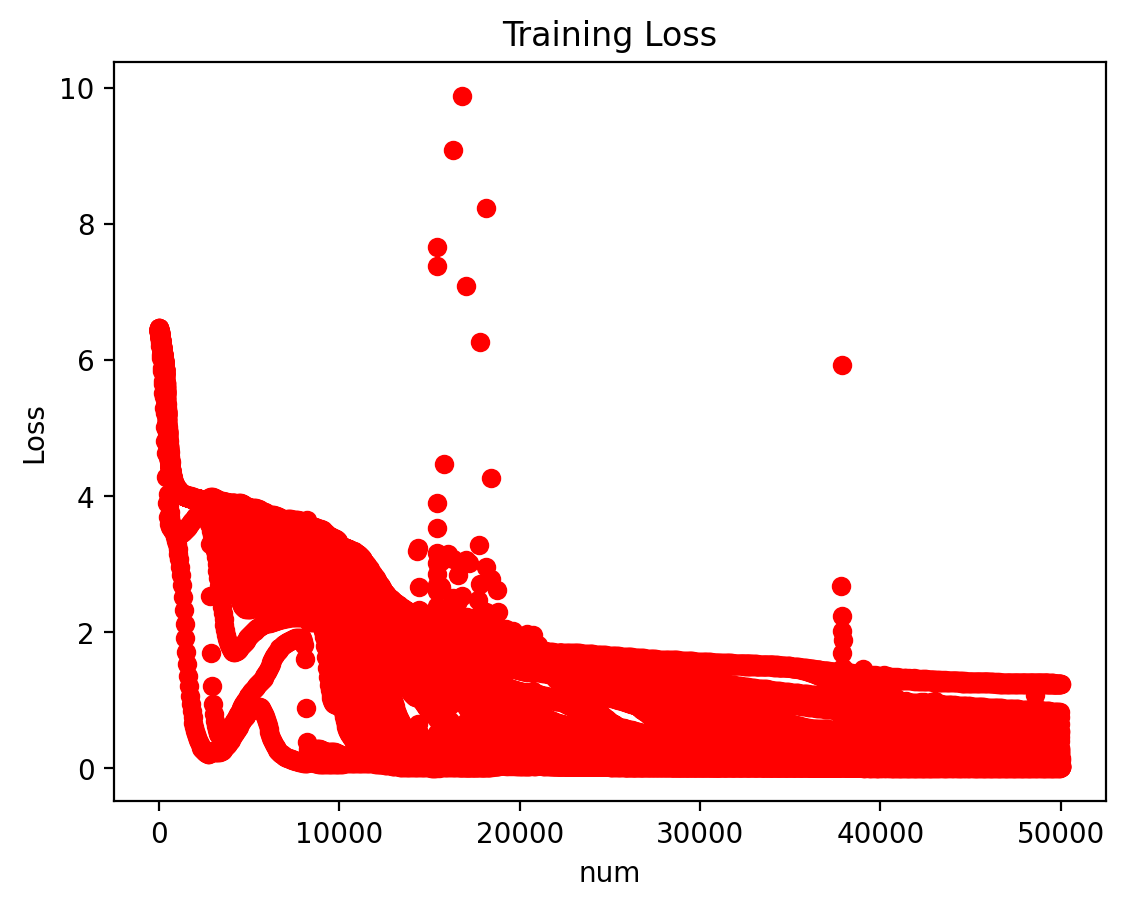

In [18]:
data = ''.join(poems)
best_params, lowest_loss = train(data, num, patience)

In [19]:
def generate_line(start_char, length=5):

    if start_char not in char_to_index:
        random_char = np.random.choice(list(vocab))
        start_index = char_to_index[random_char]
    else:
        start_index = char_to_index[start_char]

    x = np.zeros((input_size, 1))
    x[start_index] = 1
    h = np.zeros((hidden_size, 1))
    indices = [start_index]  

    for _ in range(length - 1): 
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y_hat = np.dot(Why, h) + by
        prob = np.exp(y_hat) / np.sum(np.exp(y_hat))
        next_char = np.random.choice(range(vocab_size), p=prob.ravel())
        indices.append(next_char)
        x = np.zeros((input_size, 1))
        x[next_char] = 1

    generated_poem = "".join(index_to_char[i] for i in indices)
    return start_char + generated_poem[1:]

chars = input("请输入藏头诗的头: ").split(' ')

for char in chars:
    generated_line = generate_line(char, length=5)
    print(generated_line)

春三拈鞍矗
花三初鞍矗
秋浮矗鞍悲
月三鞍厌拈


In [ ]:
import numpy as np
import pickle

np.save('Wxh.npy', Wxh)
np.save('Whh.npy', Whh)
np.save('Why.npy', Why)
np.save('bh.npy', bh)
np.save('by.npy', by)

with open('char_to_index.pickle', 'wb') as handle:
    pickle.dump(char_to_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('index_to_char.pickle', 'wb') as handle:
    pickle.dump(index_to_char, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
import numpy as np
import pickle

np.save('./peo1/Wxh.npy', Wxh)
np.save('./peo1/Whh.npy', Whh)
np.save('./peo1/Why.npy', Why)
np.save('./peo1/bh.npy', bh)
np.save('./peo1/by.npy', by)

with open('char_to_index.pickle', 'wb') as handle:
    pickle.dump(char_to_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('index_to_char.pickle', 'wb') as handle:
    pickle.dump(index_to_char, handle, protocol=pickle.HIGHEST_PROTOCOL)